In [0]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
p = Path('data')
classes=['stray_cattle','no_stray_cattle']

In [0]:
for c in classes:
        print(c)
        verify_images(p/c,delete=True)

In [0]:
p

WindowsPath('data')

In [0]:
tfms = get_transforms(do_flip=True,flip_vert=False,max_zoom=1.05,max_warp=0.1)
data = (ImageList.from_folder(p) 
        .split_by_rand_pct(0.1)              
        .label_from_folder()            
        .transform(tfms, size=128)
        .databunch(num_workers=0)).normalize(imagenet_stats)    

In [0]:
data

ImageDataBunch;

Train: LabelList (493 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
no_stray_cattle,no_stray_cattle,no_stray_cattle,no_stray_cattle,no_stray_cattle
Path: data;

Valid: LabelList (54 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
stray_cattle,stray_cattle,no_stray_cattle,stray_cattle,no_stray_cattle
Path: data;

Test: None

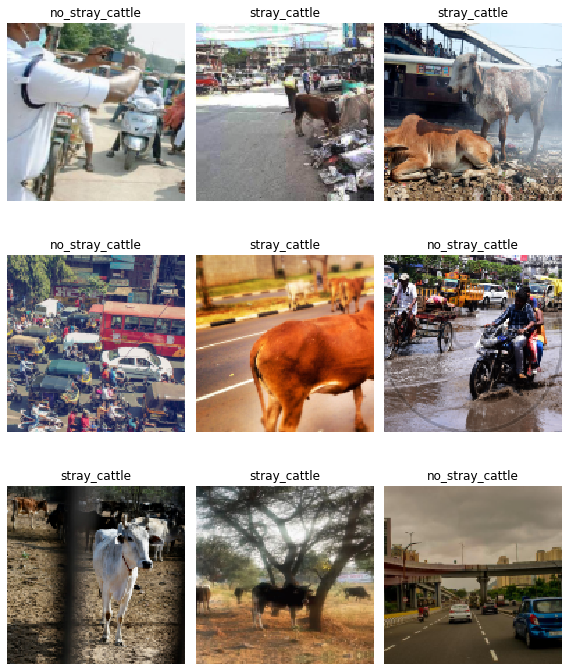

In [0]:
data.show_batch(rows=3, figsize=(8,10))

In [0]:
print(data.classes)

['no_stray_cattle', 'stray_cattle']


In [0]:
from fastai.callbacks import *

In [0]:
learn101 = cnn_learner(data, models.resnet101, metrics=[error_rate, accuracy],model_dir="models/")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 1.20E-02


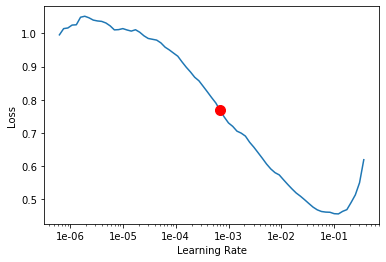

In [0]:
learn101.lr_find()
learn101.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.828087,0.240825,0.111111,0.888889,00:19
1,0.565450,0.175361,0.055556,0.944444,00:18
2,0.429431,0.188767,0.074074,0.925926,00:19
3,0.355345,0.190166,0.092593,0.907407,00:19


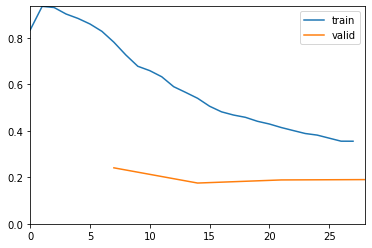

Better model found at epoch 0 with error_rate value: 0.1111111044883728.
Better model found at epoch 1 with error_rate value: 0.055555518716573715.


In [0]:
learn101.fit_one_cycle(4,5e-04,callbacks=[ShowGraph(learn101),SaveModelCallback(learn101,monitor='error_rate',mode='min',
name="bestmodel101")]) 

In [0]:
learn101.save('resnet101-4epochs-stage-1') # save model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 2.09E-04


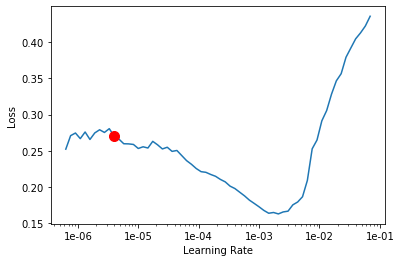

In [0]:
learn101.unfreeze() # unfreeze all layers
learn101.lr_find() # find learning rate
learn101.recorder.plot(suggestion=True) # plot learning rate

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.278008,0.203144,0.092593,0.907407,00:19
1,0.267024,0.199890,0.092593,0.907407,00:20
2,0.247972,0.198315,0.111111,0.888889,00:19
3,0.232370,0.197754,0.111111,0.888889,00:20
4,0.217815,0.192896,0.111111,0.888889,00:21


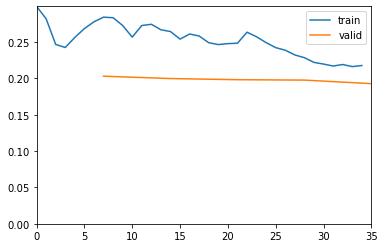

Better model found at epoch 0 with error_rate value: 0.09259258955717087.


In [0]:
learn101.fit_one_cycle(5,1e-05,callbacks=[ShowGraph(learn101),SaveModelCallback(learn101,monitor='error_rate',mode='min',
name="bestmodel101")])

In [0]:
tfms = get_transforms(do_flip=True,flip_vert=False,max_zoom=1.05,max_warp=0.1)
data = (ImageList.from_folder(p) 
        .split_by_rand_pct(0.1)              
        .label_from_folder()            
        .transform(tfms, size=256)
        .databunch(num_workers=0)).normalize(imagenet_stats)    

In [0]:
data.batch_size=8

In [0]:
learn101.data = data

In [0]:
learn101.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.45E-06


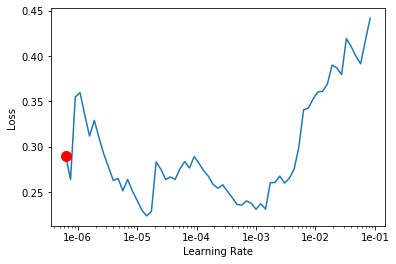

In [0]:
learn101.lr_find()
learn101.recorder.plot(suggestion=True)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.213130,0.064488,0.037037,0.962963,00:37
1,0.178951,0.053737,0.018519,0.981481,00:39
2,0.255588,0.095776,0.055556,0.944444,00:38
3,0.217750,0.056032,0.018519,0.981481,00:38
4,0.158013,0.062556,0.018519,0.981481,00:38


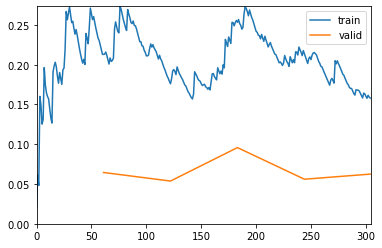

Better model found at epoch 0 with error_rate value: 0.03703703731298447.
Better model found at epoch 1 with error_rate value: 0.018518518656492233.


In [0]:
learn101.fit_one_cycle(5,5e-05,callbacks=[ShowGraph(learn101),SaveModelCallback(learn101,monitor='error_rate',mode='min',
name="bestmodel101-256")])

In [0]:
learn101.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


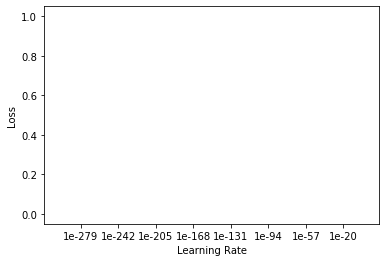

In [0]:
learn101.lr_find()
learn101.recorder.plot(suggestion=True)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.197806,0.131392,0.055556,0.944444,00:41
1,0.269487,0.172940,0.074074,0.925926,00:40
2,0.230507,0.107486,0.055556,0.944444,00:42
3,0.185618,0.073152,0.037037,0.962963,00:40
4,0.195439,0.105361,0.037037,0.962963,00:42


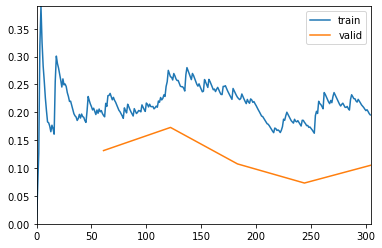

Better model found at epoch 0 with error_rate value: 0.0555555559694767.
Better model found at epoch 3 with error_rate value: 0.03703703731298447.


In [0]:
learn101.fit_one_cycle(5,1e-06,callbacks=[ShowGraph(learn101),SaveModelCallback(learn101,monitor='error_rate',mode='min',
name="bestmodel101-256-unfreeze")])

In [0]:
interp = ClassificationInterpretation.from_learner(learn101)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

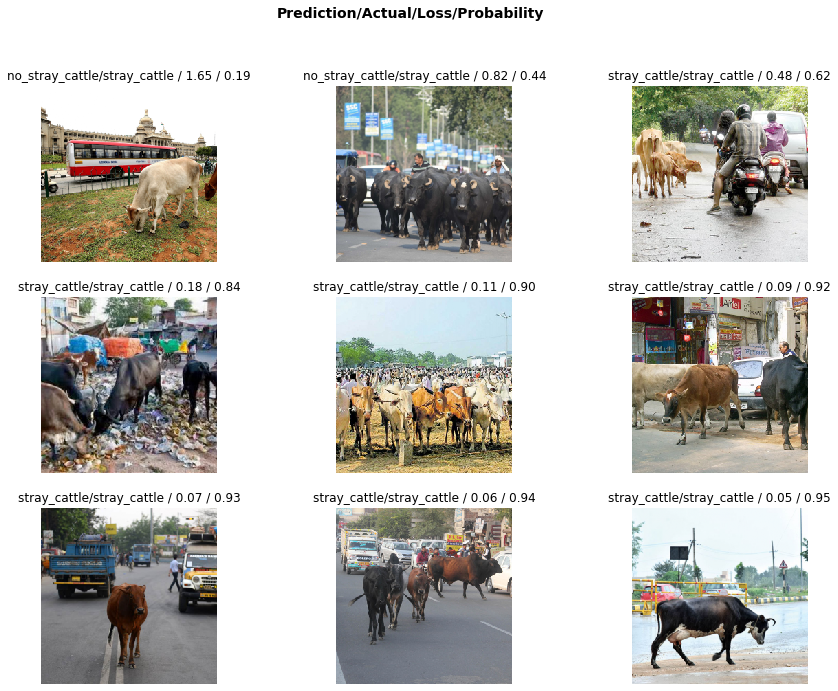

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

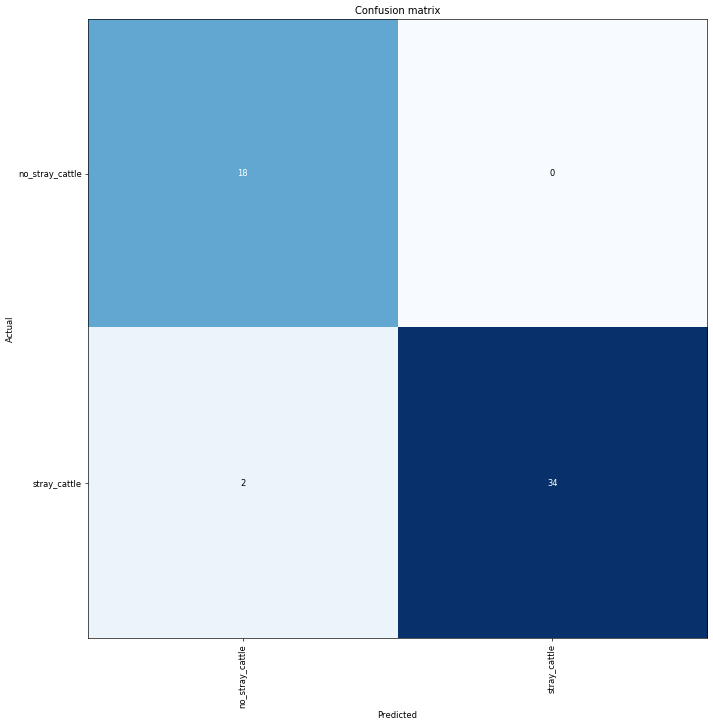

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused()

[('stray_cattle', 'no_stray_cattle', 2)]

In [0]:
learn101.load('bestmodel101-256')

Learner(data=ImageDataBunch;

Train: LabelList (493 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
no_stray_cattle,no_stray_cattle,no_stray_cattle,no_stray_cattle,no_stray_cattle
Path: data;

Valid: LabelList (54 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
no_stray_cattle,stray_cattle,stray_cattle,stray_cattle,no_stray_cattle
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm

In [0]:
interp = ClassificationInterpretation.from_learner(learn101)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

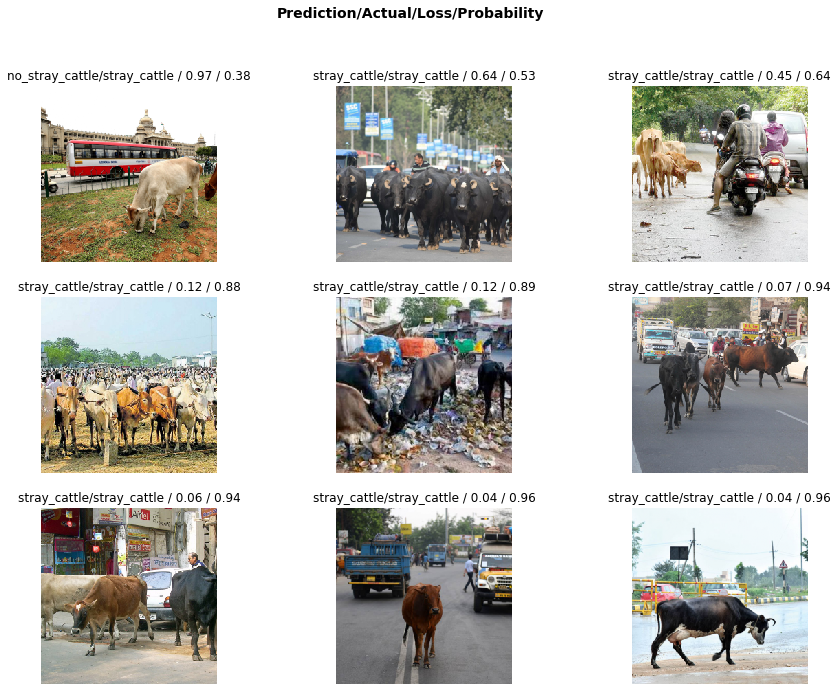

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

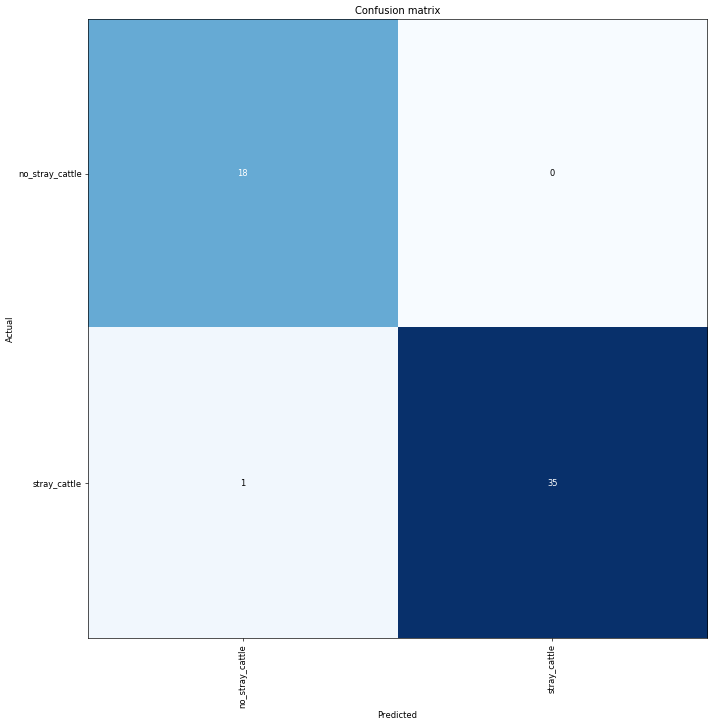

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
learn101.export()

In [0]:
path = learn101.path
print(path)

data


In [0]:
learn = load_learner(path)


In [0]:
files = ['back_single.jpg',
 'bike.jpg',
 'many.jpg',
 'many_back.jpg',
 'many_test.jpg',
 'single_cow.jpg',
 'single_cow2.jpg',
 'srinaths_cow.jpg',
 'srinaths_cow2.png',
 'street_test.jpg',
 'super_blurry.jpg',
 'test.jpg',
 'test1.jpg']

In [0]:
images = []
prediction = []
probability = []
for i in files:
      images.append(i)
      link = i
      img = open_image(link)
      pred_class,pred_idx,outputs = learn.predict(img)
      prediction.append(pred_class.obj)
      probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()

,image_name,label,probability
0,back_single.jpg,stray_cattle,0.994750
1,bike.jpg,no_stray_cattle,0.888234
2,many.jpg,stray_cattle,0.998495
3,many_back.jpg,stray_cattle,0.998578
4,many_test.jpg,stray_cattle,0.999387


In [0]:
answer

,image_name,label,probability
0,back_single.jpg,stray_cattle,0.994750
1,bike.jpg,no_stray_cattle,0.888234
2,many.jpg,stray_cattle,0.998495
3,many_back.jpg,stray_cattle,0.998578
4,many_test.jpg,stray_cattle,0.999387
5,single_cow.jpg,stray_cattle,0.999340
6,single_cow2.jpg,stray_cattle,0.952693
7,srinaths_cow.jpg,stray_cattle,0.998978
8,srinaths_cow2.png,stray_cattle,0.957701
9,street_test.jpg,no_stray_cattle,0.960727


In [0]:
link = 'srinaths_cow2.png'
img = open_image(link)

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
prediction.append(pred_class.obj)
probability.append(outputs.abs().max().item())

In [0]:
prediction

['stray_cattle']

In [0]:
probability

[0.9577008485794067]